# Práctica 6
### TDM - Máster en IoT - Rafael Caballero

Vamos a trabajar con datos de las evaluaciones Pisa por páises para tres disciplinas: ciencias (SCI), lectura (REA) y matemáticas (MAT). Los datos se han obtenido de: https://www.kaggle.com/zazueta/pisa-scores-2015

Por favor, empezad poniendo el nombre:

In [ ]:
# Nombre: 

#### Setup

In [2]:
%matplotlib inline
import os
# cambiamos las variables del sistema
spark = 'C:\\hlocal\\tdm\\spark\\hadoop\\spark-2.3.2-bin-hadoop2.7'
# en el path se añade
path = os.environ.get('PATH') 
path = path+ ';'+spark+'\\bin;'
os.environ['PATH'] = path
os.environ['SPARK_HOME']= spark 
os.environ['HADOOP_HOME']= spark 
os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

# si da problema con collect quizás haya que poner java_home
os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
#labs = 'C:\\JDK\\jdk8-64bits'
#os.environ['JAVA_HOME']= labs
os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+path


import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
print("Preparado!!")


Preparado!!


### Carga de datos
*1.* Cargar el fichero 'PisaData.csv', que contiene los resultados en las pruebas Pisa por países para los años 2013,2014,2015. 
Inicialmente lo cargamos como un RDD de texto, al que llamaremos raw_data




In [3]:
#path = 'c:\\hlocal\\tdm\\PisaData.csv'
path = 'c:\\hlocal\\tdm\\PisaData.csv' # cambiar si está en otro lugarç

raw_data = sc.textFile(path).cache() # Un RDD de strings
raw_data.take(5)

['CountryName,CountryCode,Series Name,Code,YR2013,YR2014,YR2015',
 'Albania,ALB,PISA: Mean performance on the mathematics scale,LO.PISA.MAT,..,..,413.157',
 'Albania,ALB,PISA: Mean performance on the mathematics scale. Female,LO.PISA.MAT.FE,..,..,417.750029482799',
 'Albania,ALB,PISA: Mean performance on the mathematics scale. Male,LO.PISA.MAT.MA,..,..,408.545458736189',
 'Albania,ALB,PISA: Mean performance on the reading scale,LO.PISA.REA,..,..,405.2588']

### Preprocesamiento

Vemos algunas valores tienen '..' en lugar de un valor numérico. Se tratan de datos *missing*, es decir no conocidos, para algún año, asignatura y país. El problema de estos datos es que impedirían inferir que los campos son de tipo numérico.  Como en todo caso solo nos interesa el año 2015, lo primero que vamos a hacer es quedarnos con las columnas que nos interesan, y luego descartar, si los hay, los valores missing. Lo hacemos por fases

*2*  Utilizar una operación adecuado sobre RDDs que convierta el RDD en uno de arrays de strings, donde cada componente del array es un campo. Para ellos se debe separar cada línea por el carácter , (ver notebook SparkSQL). El resultado se llamara csv_data.

In [4]:
# solución
csv_data = raw_data.map(lambda l: l.split(",")) 

# para probar
csv_data.take(5)

[['CountryName',
  'CountryCode',
  'Series Name',
  'Code',
  'YR2013',
  'YR2014',
  'YR2015'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale',
  'LO.PISA.MAT',
  '..',
  '..',
  '413.157'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale. Female',
  'LO.PISA.MAT.FE',
  '..',
  '..',
  '417.750029482799'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the mathematics scale. Male',
  'LO.PISA.MAT.MA',
  '..',
  '..',
  '408.545458736189'],
 ['Albania',
  'ALB',
  'PISA: Mean performance on the reading scale',
  'LO.PISA.REA',
  '..',
  '..',
  '405.2588']]

**3** Solo nos interesan las columnas que ocupan las posiciones 0 (CountryName), 3 (Code) y 6 (YR2015). 
Escribir la operación sobre RDDs que crea a partir de csv_data un nuevo RDD, al que llamaremos datosRDD, que solo tiene estas columnas

Pista: Dada una fila l, queremos consutruir un nuevo array con los valores l[0],l[3] y l[6]

In [5]:
datosRDD = csv_data.map(lambda l: [l[0],l[3],l[6]])

# Para probar
print(datosRDD.count()) # los mismos que csv_data:1167
datosRDD.take(5)

1167


[['CountryName', 'Code', 'YR2015'],
 ['Albania', 'LO.PISA.MAT', '413.157'],
 ['Albania', 'LO.PISA.MAT.FE', '417.750029482799'],
 ['Albania', 'LO.PISA.MAT.MA', '408.545458736189'],
 ['Albania', 'LO.PISA.REA', '405.2588']]

**4** Ahora quitamos los valores missing para la columna de índice 2. Es decir, quitamos aquellas filas cuyo valor en la columna 2 sea '..'.
El nuevo RDD se llamará *datosRDD2*

In [6]:
# 4
datosRDD2 = datosRDD.filter(lambda l: l[2]!='..')
print(datosRDD2.count()) # Quedan 582
datosRDD2.take(11)

582


[['CountryName', 'Code', 'YR2015'],
 ['Albania', 'LO.PISA.MAT', '413.157'],
 ['Albania', 'LO.PISA.MAT.FE', '417.750029482799'],
 ['Albania', 'LO.PISA.MAT.MA', '408.545458736189'],
 ['Albania', 'LO.PISA.REA', '405.2588'],
 ['Albania', 'LO.PISA.REA.FE', '434.639625546737'],
 ['Albania', 'LO.PISA.REA.MA', '375.75919916958'],
 ['Albania', 'LO.PISA.SCI', '427.225'],
 ['Albania', 'LO.PISA.SCI.FE', '439.442962901842'],
 ['Albania', 'LO.PISA.SCI.MA', '414.957643727778'],
 ['Algeria', 'LO.PISA.MAT', '359.6062']]

In [7]:
# Ignorar, solo como curiosidad.
'''
# este código se encarga de trasponer los datos anteriores de forma que cada país 
# aparezca una sola vez y tenga 10 columnas asociadas, una por medida
from itertools import islice

# quitamos la primera fila
sinHeader = datosRDD2.mapPartitionsWithIndex(
    lambda idx, it: islice(it, 1, None) if idx == 0 else it 
)
# convertimos cada uno en parejas
parejas = sinHeader.map(lambda l: (l[0],[l[2]]))
print(parejas.take(5))
paises = parejas.reduceByKey(lambda a,b:[a[0]+','+b[0]]).map(lambda a:a[0]+','+a[1][0])
paises.take(5)
print(paises.count())

opath= 'c:\\hlocal\\tdm\\PisaData2.csv'
paises.saveAsTextFile(opath)
# nota, habría que añadir las cabeceras
'''

"\n# este código se encarga de trasponer los datos anteriores de forma que cada país \n# aparezca una sola vez y tenga 10 columnas asociadas, una por medida\nfrom itertools import islice\n\n# quitamos la primera fila\nsinHeader = datosRDD2.mapPartitionsWithIndex(\n    lambda idx, it: islice(it, 1, None) if idx == 0 else it \n)\n# convertimos cada uno en parejas\nparejas = sinHeader.map(lambda l: (l[0],[l[2]]))\nprint(parejas.take(5))\npaises = parejas.reduceByKey(lambda a,b:[a[0]+','+b[0]]).map(lambda a:a[0]+','+a[1][0])\npaises.take(5)\nprint(paises.count())\n\nopath= 'c:\\hlocal\\tdm\\PisaData2.csv'\npaises.saveAsTextFile(opath)\n# nota, habría que añadir las cabeceras\n"

### Carga de datos (2)

**5.** Cargar el fichero 'PisaDataBis.csv', que contiene los resultados en las pruebas Pisa por países para 2015. Utilizar el método 'fácil' que permite leer todo el fichero como una dataframe, infiriendo el esquema. Llamar al dataframe 'datos_df'

Nota: El fichero contiene cabeceras

In [8]:
# path = 'c:\\hlocal\\tdm\\PisaDataBis.csv'
# Cambiar si el path es diferente
path = 'c:\\hlocal\\tdm\\PisaDataBis.csv'

# solucion; debe crear un dataframe datos
datos_df = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(path)

print(datos_df.count()) # 64
datos_df.printSchema()
datos_df.take(5)


64
root
 |-- PAIS: string (nullable = true)
 |-- MAT: double (nullable = true)
 |-- MAT_FE: double (nullable = true)
 |-- MAT_MA: double (nullable = true)
 |-- REA: double (nullable = true)
 |-- REA_FE: double (nullable = true)
 |-- REA_MA: double (nullable = true)
 |-- SCI: double (nullable = true)
 |-- SCI_FE: double (nullable = true)
 |-- SCI_MA: double (nullable = true)



[Row(PAIS='Albania', MAT=413.157, MAT_FE=417.750029482799, MAT_MA=408.545458736189, REA=405.2588, REA_FE=434.639625546737, REA_MA=375.75919916958, SCI=427.225, SCI_FE=439.442962901842, SCI_MA=414.957643727778),
 Row(PAIS='Algeria', MAT=359.6062, MAT_FE=363.072479076874, MAT_MA=356.495105666181, REA=349.8593, REA_FE=366.208166798086, REA_MA=335.185435908668, SCI=375.7451, SCI_FE=383.220938935314, SCI_MA=369.035233788056),
 Row(PAIS='Argentina', MAT=409.0333, MAT_FE=400.443116055612, MAT_MA=418.388360865522, REA=425.3031, REA_FE=432.95807959441, REA_MA=416.966607209736, SCI=432.2262, SCI_FE=424.994351346692, SCI_MA=440.102029698007),
 Row(PAIS='Australia', MAT=493.8962, MAT_FE=490.985500770373, MAT_MA=496.761344887127, REA=502.9006, REA_FE=518.865799240277, REA_MA=487.18552546683, SCI=509.9939, SCI_FE=508.921647404582, SCI_MA=511.049257232073),
 Row(PAIS='Austria', MAT=496.7423, MAT_FE=483.133026052429, MAT_MA=510.098215924204, REA=484.8656, REA_FE=495.075191103096, REA_MA=474.8460316092

### Estadísticas básicas


**6** Dibujar el histograma correspondiente a la columna 'SCI' que da los datos globales en ciencias. Usar un gráfico de 23 barras en azul.


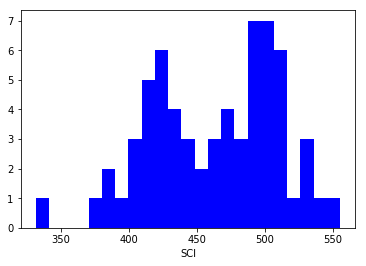

In [9]:
%matplotlib inline
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
col = 'SCI'
hist(ax, datos_df.select([col]), bins = 23, color=['blue'])
plt.xlabel(col)
plt.show()


**7** Observamos algo curioso: la gráfica parece tener varios 'picos' (¿varias normales superpuestas?). 
    Escribir una instrucción en SPARKSQL que nos devuelva un dataframe los países que están por debajo de 450. 
    El nuevo dataframe recibirá como nombre menor_df. 
    
    Utilizar una instrucción filter de SPARK SQL, seguida de un select para tomar solo la columna país
    
    https://stackoverflow.com/questions/45978108/multiple-condition-filter-on-dataframe

In [10]:
# solución
menor_df = datos_df.filter('SCI < 440').select(['PAIS','SCI'])

# quitar comentario para probar
#menor_df.show()

 **8** Número de países en los que las mujeres son peores en lectura que los hombres (REA_FE < REA_MA)
 
 Ayuda: El resultado es ¡0!

In [11]:
datos_df.filter('REA_FE < REA_MA').count()

0


Vemos que corresponden a países con renta per capita no muy alta. Digamos que el histograma muestra las diferencias en renta

**9**  ¿Es la correlación entre SCI (columna 7 de datos_df) y MAT (columna 1) es mayor que la correlación entre SCI y REA (columna 4)?. Mostrar ambos valores. Ayuda: Ver SparkSQL, justo antes de 'muestras'

In [12]:
from pyspark.sql.functions import corr
import math 

sci = 7
mat = 1
rea = 4

sci_mat = datos_df.select(corr(datos_df.columns[sci], datos_df.columns[mat])).first()
sci_rea = datos_df.select(corr(datos_df.columns[sci], datos_df.columns[rea])).first()

print("corr. sci-mat: ",sci_mat,' corr. sci-rea: ',sci_rea)
       

corr. sci-mat:  Row(corr(SCI, MAT)=0.9744212449079869)  corr. sci-rea:  Row(corr(SCI, REA)=0.9625212644401843)


**10** Queremos saber qué decil ocupa españa en ciencias (SCI). Para ello

1. Obtendremos el valor de españa en ciencias
2. Calcularemos los deciles de la columna sci con la función approxQuantile (sobre la que debemos buscar información en internet). Usar como cota del error el valor 0.
3. Mostraremos el decil por pantalla (D1 si está en el mejor 10%, D2 si está en el top 20%, y así hasta D10 si está en el peor 10%)

In [16]:
# solución

# dato de españa
spa = datos_df.filter("PAIS='Spain'").select(['SCI']).first()[0]

# deciles
quantiles = datos_df.approxQuantile("SCI", [ i*0.1 for i in range(1,10) ], 0) 

# buscar hueco
i=0
while i<=8 and quantiles[i]<spa:
    i+=1
print('D'+str(10-i))    

D4
